# Introduction to k-Nearest Neighbor

-----

In this notebook, we introduce one of the simplest machine learning algorithms, [**k-nearest neighbors**][wknn] (KNN), and demonstrate how to effectively use this algorithm to perform both classification and regression. This algorithm works by finding the $K$ nearest neighbors to a new instance and using the features of these neighbors to predict the feature for the new instance. If the feature is discrete, such as a class label, the prediction is classification. If the feature is continuous, such as a numerical value, the prediction is regression.

The KNN algorithm is different than most other algorithms in several ways. First, the algorithm is a lazy learner in that no model is constructed. Instead, the predictions are made straight from the training data. Thus, the `fit` method in the relevant scikit-learn [KNN estimator][sknn] doesn't build a model; instead, it builds an efficient representation of the training data, in other words, it stores all training data. Since the KNN algorithm stores all of the training data in the model, when the dataset is large, KNN requires more memory. Second, this algorithm is non-parametric, which means it does not make any assumptions on the underlying data distribution.

To understand why this algorithm works, simply look at society in general. You likely live near people who are like you in income, educational level, and religious or political beliefs. These inherent relationships are often captured in data sets and can thus be used by neighbor algorithms to make reasonable predictions. At its simplest, one neighbor is used, and the feature from this neighbor is used to make the prediction. As more neighbors are added, however, a descriptive statistic can be applied to the nearest neighbor features. Often this is the mode for a discrete prediction or the mean value for a continuous prediction; but other statistics can also be used. In addition, we can weight the statistic to account for the proximity of different neighbors. Thus, we may use a weighted mean for a regression prediction.

This notebook first introduces the underlying formalism of the KNN algorithm, which includes a discussion of distance metrics.  
Next, we will demonstrate the KNN algorithm by classifying the iris data.  
Then, we will apply KNN on a more practical dataset, the adult income data.  
Finally, we will demonstrate the KNN regressor with Auto MPG data.

-----
[wknn]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
[sknn]: http://scikit-learn.org/stable/modules/neighbors.html

## Table of Contents

[Formalism](#Formalism)

[K-Nearest Neighbors: Classification](#K-Nearest-Neighbors:-Classification)

[Classification: Adult Data](#Classification:-Adult-Data)

[K-Nearest Neighbors: Regression](#K-Nearest-Neighbors:-Regression)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

Fundamentally, this algorithm is remarkably simple and is based on the principle that data values in an $N$- dimensional space are generally located near other similar objects. The number of nearest neighbors, `K`, is a tuning parameter, and can be specified a priori, or in some algorithms empirically determined. The basic principle behind KNN is demonstrated in the figure generated by the following Code cell. This Code cell generates random data (excluding a circle near the sample point for clarity), and uses the scikit-learn [`NearestNeighbors`][sknn] estimator to find the $K$ nearest neighbors. We use this information to construct arrows in the plot between our sample point of interest and the nearest neighbors.

__Note__: You are **not** required to understand the code. Pay more attention to the plot which demonstrates the concept of _neighbors_. 

-----

[sknn]: http://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

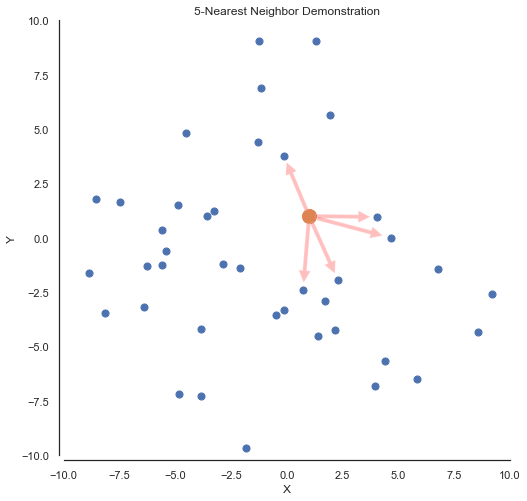

In [2]:
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors

# Parameters for demonstration
num_pts = 40
num_nbrs = 5

sample_point = np.array([1, 1])

# Set random state for reproducability
rng = np.random.RandomState(23)

# Random radial and theta data in ring
radius = rng.uniform(2.5, 10.0, num_pts)
theta = rng.uniform(0, 360, num_pts)

# Transform to Cartesian
x = radius * np.sin(theta)
y = radius * np.cos(theta)

# Stack data into two-dimensional array
data = np.hstack((x.reshape(num_pts, 1), y.reshape(num_pts, 1)))

# Create nearest neighbors estimator
nbrs = NearestNeighbors(n_neighbors=num_nbrs).fit(data)

# Compute distances and indices of nearest neighbors
distances, indices = nbrs.kneighbors(sample_point.reshape(1, -1))

# Flatten the matrices to vectors
distances = distances.flatten()
indices = indices.flatten()

# Set up plot area
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and sample point
ax.scatter(x, y, s=50, cmap=cm.coolwarm)
ax.scatter(sample_point[0], sample_point[1], s=200, cmap=cm.coolwarm)

# Loop over neighbors
for idx in range(num_nbrs): 
    # Draw an arrow between sample point and neighbor
    ax.annotate('', xytext=sample_point, xy=data[indices[idx]],
                arrowprops=dict(facecolor='red', alpha=0.25, shrink=0.1))

# Decorate plot
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set(xlabel = 'X', ylabel='Y', title=f'{num_nbrs}-Nearest Neighbor Demonstration')
sns.despine(offset=5, trim=True)

-----

As shown in the previous plot, when a new datum is added (e.g., the large green point), the KNN algorithm first identifies the $k$ nearest neighbors. (In the example above this is five by default, shown by the red arrows to the nearest five blue points). Given these nearest neighbors, a statistical evaluation of their relevant feature is performed, and the result is used to make the prediction for the new data point. The statistical evaluation can be simple, such as choosing the mode from a set of discrete classes. Or it can be more complex, such as choosing the weighted mean of the features from the nearest neighbors, where the weight might be determined by the relative distance of each neighbor from the datum of interest.

Fundamental to this algorithm is the concept of **distance**. To this point we have simply assumed the features used to define _neighbors_ followed a standard Euclidean distance (i.e., normal spatial coordinates). While this is often the case, some problems require a different distance. The next subsection explores this concept in more detail.

-----

### Distance Measurements

To determine neighbors, we must adopt a definition for the distance. Naively, we might think this is simple; we adopt the common concept of distance that underlies the Pythagorean theorem: $d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$ where $d$ is the distance between two-dimensional points $(x_1, y_1)$ and $(x_2, y_2)$. However, this is really only true for data that follow a [Euclidean distance][wed] metric, such as points on a cartesian plot. This is not true for calculating other distances, even spatial ones, such as the distance a plane flies on a long-distance flight. Furthermore, many data likely require an alternative definition of distance. For example, currency data, categorical data, or text data all likely require different definitions for distance.

Formally, a [_metric_][wm] defines how distances are measured for a particular set of data. The scikit-learn library supports different [distance metrics][skdm] in the `neighbors` module. Some of the standard metrics in this module include:

- [`euclidean`][wed]: Supports the standard concept of spatial distance.
- [`manhattan`][wmd]: Restricts distance measurements to follow grid lines. This metric is sometimes referred to as the Taxi-cab distance, since taxis must follow streets, which also gives rise to its formal name, _manhattan_, for the street grid on the island of Manhattan.
- [`haversine`][whd]: Calculates the distance travelled over the surface of a sphere, such as the Earth.
- [`chebyshev`][wcd]: Assumes the distance is equal to the greatest distance along the individual dimensions.
- [`minkowski`][wmd]: A generalization of the Manhattan and Euclidean distances to arbitrary powers.

The detail of these metrics are out of the scope of this course.

-----
[wm]: https://en.wikipedia.org/wiki/Metric_(mathematics)

[skdm]: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
[wed]: https://en.wikipedia.org/wiki/Euclidean_distance
[wcd]: https://en.wikipedia.org/wiki/Chebyshev_distance
[wmd]: https://en.wikipedia.org/wiki/Taxicab_geometry
[whd]: https://en.wikipedia.org/wiki/Haversine_formula
[wmd]: https://en.wikipedia.org/wiki/Minkowski_distance

---
### How to Choose K

Choice of K in KNN is very critical. As shown in below image, when K=3, the data point represented by the red star is classified as blue dot; when k=6, 4 out of 6 nearest neighbors are yellow dots; thus the data point is classified as yellow dot.

<img src='images/knn.png' width=500>

Some general rules to choose proper K are:
- K can't be too small - a too small value of k means that noise will have a higher influence on the result.
- K can't be too large - a too large value makes KNN bias towards to the major class in the training dataset. An extreme case is when K equals to the size of the training data. Then in a classification problem, all test data will be predicted as the largest class in the training dataset; in a regression problem, the mean of training output will always be the prediction.
- Rule of thumb is to set K close to sqrt(N)/2, where N is the size of training dataset.
- For classifcation, K is better to be odd number if there are 2 classes to avoid a tie.
- For classifcation, K is better not to be multiples of number of classes to avoid a tie.

We can determine optimal K value programmatically. The basic idea is to compare model accuracy for different K and choose K that gives the most accurate model. We will discuss this topic in more detail in the future lessons.


-----

[[Back to TOC]](#Table-of-Contents)

## K-Nearest Neighbors: Classification

To apply the k-nearest neighbors algorithm to classification tasks we will use the `KNeighborsClassifier` estimator from the scikit-learn `neighbors` module. This estimator accepts a number of hyperparameters, including:

- `n_neighbors`: Number of neighbors to use, default is 5.
- `weights`: Weight function used in prediction. The scikit-learn neighbors module supports three different values for the weight hyperparameter. By default, `'uniform'` weighting is used, which means each neighbor is treated equally. The other simple choice for the weight hyperparameter is to use `'distance'` weighting, where the features from different neighbors are weighted by the inverse of their distance. Thus, closer points are weighted more than distant neighbors. Finally, the third option for this hyperparameter is to provide a user-defined function that accepts an array of distances and returns the appropriate weights. 
- `metric` : The distance metric to use.  The default metric is `'minkowski'`.

Run `help(KNeighborsClassifier)` to view more details about the model and the complete list of hyperparameters.

We can now apply the KNN algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Load Iris data
2. Encode species column to create a numeric label column.
3. Split the data into training and testing sets.
4. Import the module.
5. Create the estimator, [`KNeighborsClassifier`][skknc] and specify hyperparameters. In this case we need to specify the number of neighbors, but we can use the default weight, which is `uniform`.
6. Fit the model to the training data.
7. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following Code cells.

Note that by default, the classification from the features of multiple neighbors is done by a simple majority vote (which is equivalent to the mode of the discrete labels). Finally, if multiple neighbors are at the same distance but have different labels, the ordering of the trading data will impact which label is used in the voting process.

-----
[skknc]: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [3]:
iris_df = pd.read_csv('iris.csv')
from sklearn.preprocessing import LabelEncoder
#create new column to hold encoded species
iris_df['species_cat'] = LabelEncoder().fit_transform(iris_df.species)
iris_df.sample(5, random_state=1)

,sepal_length,sepal_width,petal_length,petal_width,species,species_cat
14,5.8,4.0,1.2,0.2,setosa,0
98,5.1,2.5,3.0,1.1,versicolor,1
75,6.6,3.0,4.4,1.4,versicolor,1
16,5.4,3.9,1.3,0.4,setosa,0
131,7.9,3.8,6.4,2.0,virginica,2


In [4]:
from sklearn.model_selection import train_test_split
#Define data and label
data = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
label = iris_df['species_cat']
# Split data into training and testing
d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# First we construct our model
knc = KNeighborsClassifier(n_neighbors=5)

# Now train our model
knc.fit(d_train, l_train)

# Compute and display accuracy score
score = 100.0 * knc.score(d_test, l_test)
print(f"KNN 5 neighbors) prediction accuracy = {score:5.1f}%")

KNN 5 neighbors) prediction accuracy =  98.3%


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data and report scores
predicted = knc.predict(d_test)
labels = ['Setosa', 'Versicolor', 'Virginica']

print(classification_report(l_test, predicted, target_names = labels))
print(confusion_matrix(l_test, predicted))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.95      1.00      0.97        18
   Virginica       1.00      0.95      0.98        21

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

[[21  0  0]
 [ 0 18  0]
 [ 0  1 20]]


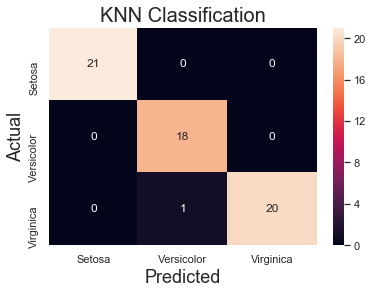

In [7]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test, predicted, labels, 'KNN Classification')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we generated a classification model for the Iris data. Modify the previous Code cells to make the following changes, and comment on how the performance of the classifier changes.


1. Change the cross-validation split size; for example change from a 75%:25% to a 50%:50%?
2. Change the number of neighbors to 1, 5, and 10.


-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform classification by using KNN. We will use the [Adult Income Dataset][uciad] introduced in the previous lesson notebooks. 

In the following two Code cells, we first prepare data. We will choose `Age`, `HoursPerWeek`, `CapitalGain`, `Sex`, ` MaritalStatus`, `Relationship` and `Race` as our training features. Feature selection is an important step in data preparation and we will discuss it in more details in future lessons. 

Next, we will encode the categorical features that have string values. KNN relies on distance, so it doesn't work very well in general when features are in different scale or unit. This is especially true when the features have both continuous and categorical features. You can define your own distance metric based on the dataset, but this is out of the scope of this course. In this notebook, we will simply encode string values to numerical values. An alternative is to create dummy variables.


-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [8]:
# Read CSV data
adult_data = pd.read_csv('data/adult_income.csv')

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Encode Sex column to numerical value
adult_data['Sex_code'] = LabelEncoder().fit_transform(adult_data.Sex)
adult_data['MaritalStatus_code'] = LabelEncoder().fit_transform(adult_data.MaritalStatus)
adult_data['Relationship_code'] = LabelEncoder().fit_transform(adult_data.Relationship)
adult_data['Race_code'] = LabelEncoder().fit_transform(adult_data.Race)
data = adult_data[['Age', 'HoursPerWeek', 'CapitalGain', 'Sex_code', 'MaritalStatus_code',
                   'Relationship_code', 'Race_code']]
label = adult_data['Label']
#display label class count
print(label.value_counts())
# Display random sample
data.sample(5)

0    3084
1     916
Name: Label, dtype: int64


,Age,HoursPerWeek,CapitalGain,Sex_code,MaritalStatus_code,Relationship_code,Race_code
496,28,65,0,1,4,1,4
1308,67,41,0,0,0,4,2
535,28,40,0,0,4,1,4
1352,27,45,0,0,4,1,4
2283,35,40,0,1,0,1,0


-----

With our features and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first split dataset to training and testing. Next, we create our KNN classifier and train the model with training dataset. And then, we measure its performance on our testing data. 

In the first Code cell, we start by splitting our data into training and testing samples. Next, we create the `KNeighborsClassifier` estimator. The only hyperparameter that we specify at this time is  `n_neighbors` with value 5. The default value of `n_neighbors` is 5, so it's not necessary to set it explicitly. We set it here just to encourage you play with different values. Then, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display the full classification report followed by the confusion matrix.


----

In [9]:
from sklearn.neighbors import KNeighborsClassifier

d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

# First we construct our model
knc = KNeighborsClassifier(n_neighbors=5)

# Now train our model
knc.fit(d_train, l_train)

# Compute and display accuracy score
score = 100.0 * knc.score(d_test, l_test)
print(f"KNN 5 neighbors) prediction accuracy = {score:5.1f}%")

KNN 5 neighbors) prediction accuracy =  80.0%


Decision Tree Classification [Adult Data] Score = 80.0%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1211
           1       0.61      0.49      0.54       389

    accuracy                           0.80      1600
   macro avg       0.73      0.69      0.71      1600
weighted avg       0.79      0.80      0.79      1600




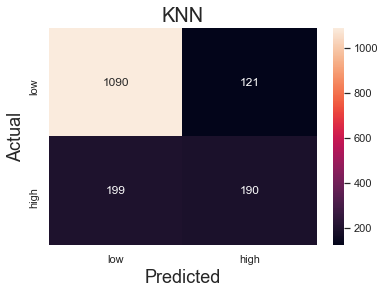

In [10]:
from sklearn import metrics
predicted = knc.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print(f'Classification Report:\n {metrics.classification_report(l_test, predicted)}\n')
ml.confusion(l_test, predicted, ['low', 'high'], title='KNN')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a KNN for classification and applied it to the adult income prediction task. The initial result was reasonable but try making the following changes to see if you can do better.

1. Change the features used in the classification; for example add one or more columns such as Education. Do the results change? 
2. Try using different hyperparameter values, such as higher `n_neighbors`. How does the change affect the results?



-----

[[Back to TOC]](#Table-of-Contents)

## K-Nearest Neighbors: Regression

As is the case with many of the supervised learning algorithms implemented in the scikit-learn library, the KNN algorithm can be used for classification (as demonstrated previously) and for regression. To generate a regression model by using the KNN algorithm we must create a [`KNeighborsRegressor`][skkr] estimator, which simply predicts a continuous value by taking the mean of the continuous labels from the nearest neighbors. Thus, while simple, this approach is often not optimal unless a large number of neighbors with many features are used.

K-nearest neighbor regression is demonstrated with the [automobile fuel performance prediction data][uciap] in the following two Code cells. 

In the first Code cell, we load the auto mpg data, select dependent and independent variables, then split the dataset to training and testing.

In the second Code cell, we compute our k-nearest neighbor regression by using five neighbors and uniform weighting schemes, both of which are actual default argument values. We then print the regression performance metrics.

-----

[skkr]: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [11]:
auto_data = pd.read_csv('mpg.csv')

y = auto_data['mpg']
auto_data['origin_code'] = LabelEncoder().fit_transform(auto_data.origin)
x = auto_data[['cylinders', 'displacement', 'weight', 'acceleration', 'model_year', 'origin_code']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=23)

x.sample(5)

,cylinders,displacement,weight,acceleration,model_year,origin_code
206,4,140.0,2565,13.6,76,2
337,4,107.0,2290,17.0,80,1
159,8,351.0,4657,13.5,75,2
133,6,250.0,3781,17.0,74,2
201,6,250.0,3645,16.2,76,2


In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(x_train, y_train)
y_pred = knr.predict(x_test)

# Copute performance metrics
mr2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display metrics
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Mean Absolute Error   = {mae:4.2f}')

R^2 Score             = 0.624
Mean Squared Error    = 20.24
Mean Absolute Error   = 3.37


---
### Scaling Features
KNN makes prediction by **distance**, which is sensitive to feature scales, so that scaling features normally would improve the model performance. In the following Code cell, we scale the features with MinMaxScaler(introduced in Module 1) before applying KNN regressor. We achieve a lot better result as the metrics show.

---

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Create and fit scaler
ss = MinMaxScaler().fit(x_train)
x_train_ss = ss.transform(x_train)
x_test_ss = ss.transform(x_test)

y_pred = knr.fit(x_train_ss, y_train).predict(x_test_ss)
mr2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display metrics after scaling features
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Mean Absolute Error   = {mae:4.2f}')

R^2 Score             = 0.823
Mean Squared Error    = 9.52
Mean Absolute Error   = 2.23


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a KNN for regression and applied it to the MPG data. The initial result was reasonable, but try making the following change to see if you can do better.

1. Try using different hyperparameter values, such as higher `n_neighbors` or different `weights`. How do the changes affect the results?

-----

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. An article by Saravanan Thirumuruganathan detailing the [KNN algorithm][1]
2. Scikit-Learn information on [Distance Metrics][3], which are used in the neighbor algorithms

-----

[1]: https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/
[2]: http://bigdata-madesimple.com/k-nearest-neighbors-curse-dimensionality-python-scikit-learn/
[3]: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
[4]: https://medium.com/towards-data-science/the-use-of-knn-for-missing-values-cf33d935c637